In [31]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import Rosenbrock
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [32]:
class DixonPrice(Rosenbrock):
    """Three-hump camel function

    Details: https://www.sfu.ca/~ssurjano/camel6.html


    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """
    
    def __init__(self, dim=10,ep = 1):
        self.min = 0
        self.dim = dim
        self.minimum = np.array([2**(-((2)**(i) - 2)/2**i) for i in range(1,dim+1)])
        self.lb = -10.0 * np.ones(dim)
        self.ub = 10.0 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = "d-dimensional Dixon-Price function "

    def eval(self, x):
        """Evaluate the Three Hump Camel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        return (x[0] - 1)**2 + np.sum(np.array([i*(2*x[i]**2 - x[i - 1])**2 for i in range(1,self.dim)]))

In [115]:
class Lm_DixonPrice(DixonPrice):

    
    def __init__(self,ep = 1,dim = 10):
        self.ep = ep
        DixonPrice.__init__(self,dim)
        #self.c = self.eval(np.random.random(size = self.dim))
        self.c = 0
        self.H_ys = []
        self.beta = 1/ep
        

            # linear f
    def eval1(self, x):
        """Evaluate the modified ThreeHumpCamel function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #print('o')
        #print(H_y)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified ThreeHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified ThreeHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
           # self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )

In [34]:
def ex_helper(times):
    max_evals = 500
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_dixonPrice = Lm_DixonPrice()
        rbf = RBFInterpolant(dim=lm_dixonPrice.dim, lb=lm_dixonPrice.lb, ub=lm_dixonPrice.ub, kernel=CubicKernel(), tail=LinearTail(lm_dixonPrice.dim))
        slhd = SymmetricLatinHypercube(dim=lm_dixonPrice.dim, num_pts=2 * (lm_dixonPrice.dim + 1))
        controller1 = SerialController(objective=lm_dixonPrice.eval)
        controller1.strategy = SRBFStrategy(
            max_evals=max_evals, opt_prob=lm_dixonPrice, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
            )

        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [35]:
l2 = ex_helper(30)

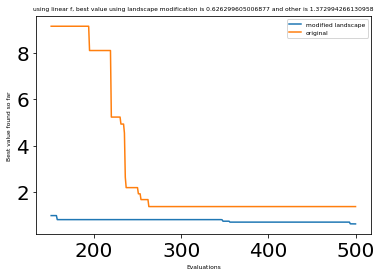

(0.626299605006877, 1.372994266130958)

In [116]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/surrogate optimization research/pySOT-master/dixon_price/square root landscape/zero_c'
# when I do it serially and also not asynchronously I am able to make it deterministic

    
def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 500
    
    lm_DixonPrice = Lm_DixonPrice()
    rbf = RBFInterpolant(dim=lm_DixonPrice.dim, lb=lm_DixonPrice.lb, ub=lm_DixonPrice.ub, kernel=CubicKernel(), tail=LinearTail(lm_DixonPrice.dim))
    slhd = SymmetricLatinHypercube(dim=lm_DixonPrice.dim, num_pts=2 * (lm_DixonPrice.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_DixonPrice.eval3)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_DixonPrice, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

    # Run the optimization strategy
    result = controller.run()
    l1 = lm_DixonPrice.H_ys

    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1[150:500],fvals2[150:500]]:
        plt.errorbar(np.arange(start = 150, stop = 500)+1, y=results)
    plt.ylabel("Best value found so far", fontsize=6)
    plt.xlabel("Evaluations", fontsize=6)
    plt.legend(("modified landscape", "original"), fontsize=6)
    plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
              format(lm_DixonPrice.eval(result.params[0]),min(l2[:,i])),
              fontsize = 6)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 200)
    plt.show()

    
    return lm_DixonPrice.eval(result.params[0]),min(l2[:,i])
    


example_simple(0,path,0,l2)

In [117]:
def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('dixon price, square root landscape modification, zero c')
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

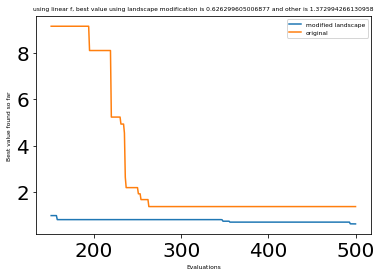

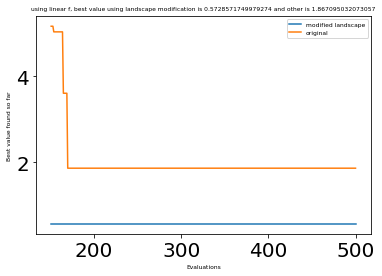

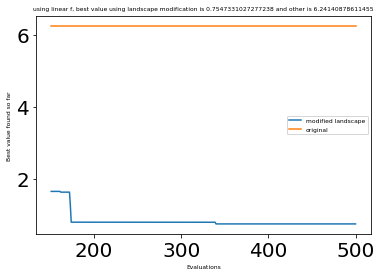

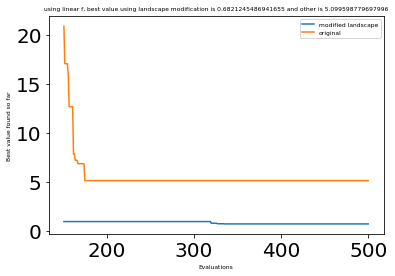

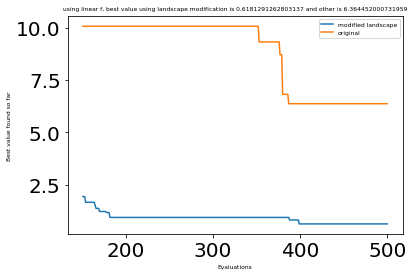

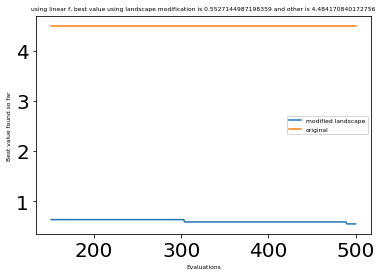

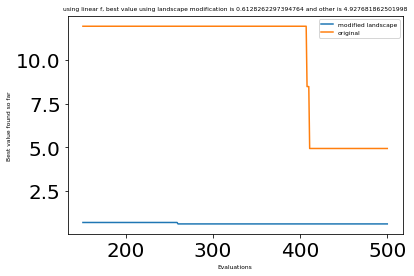

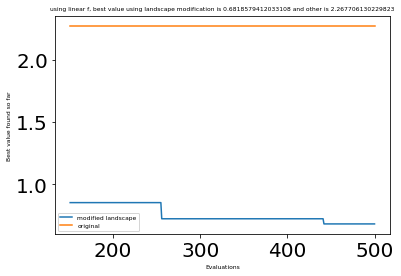

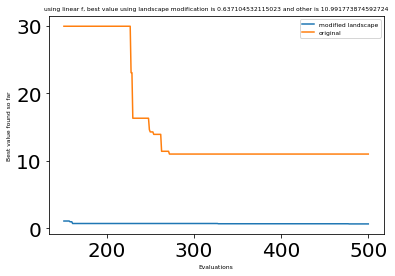

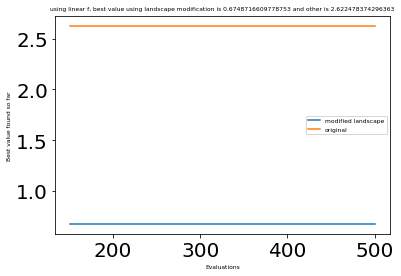

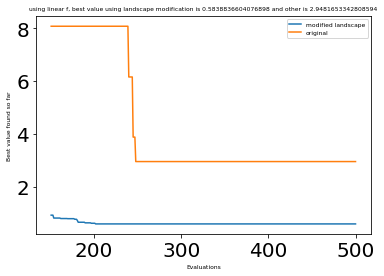

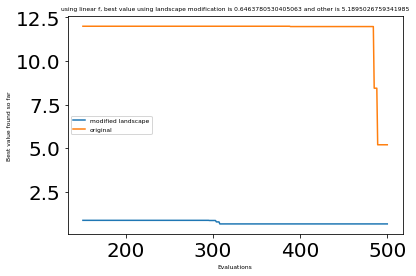

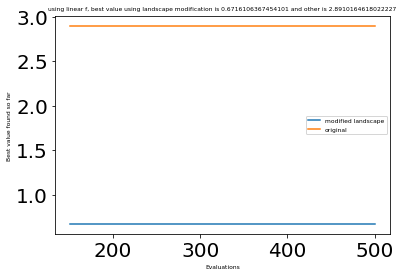

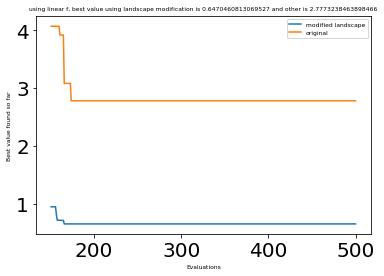

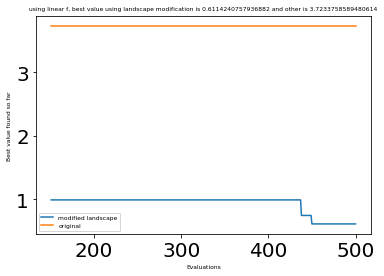

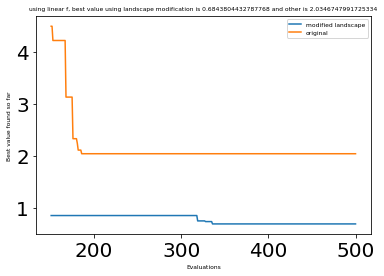

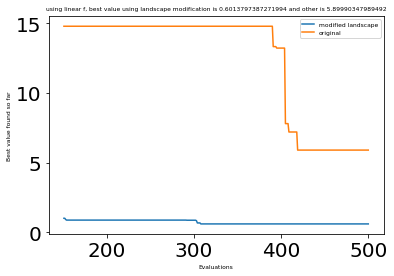

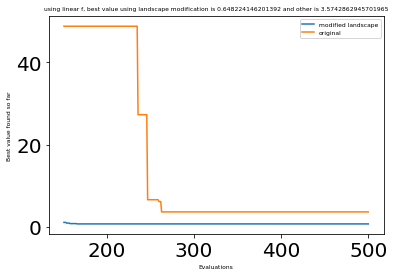

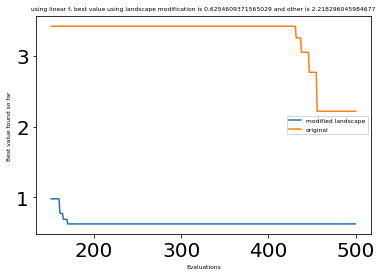

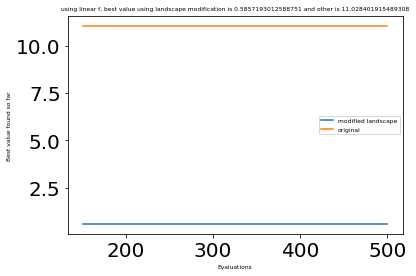

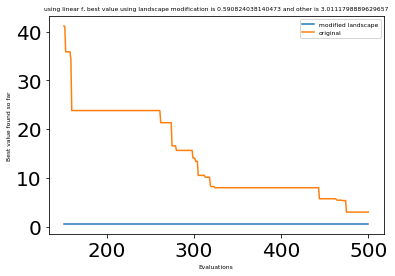

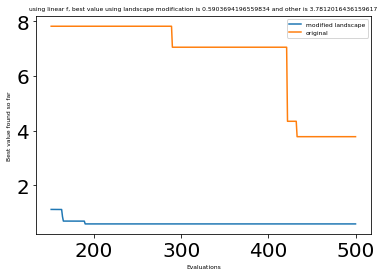

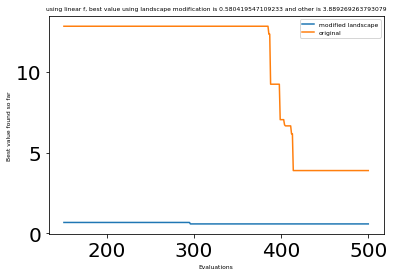

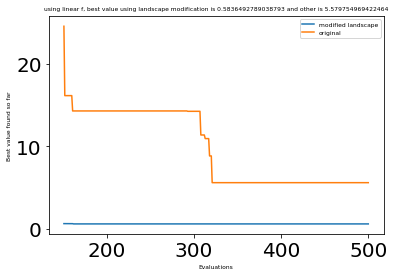

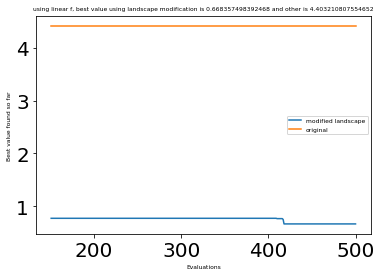

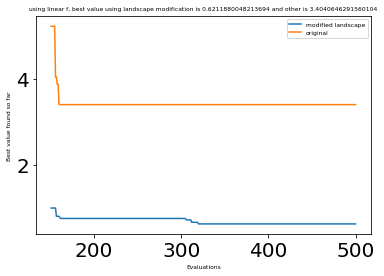

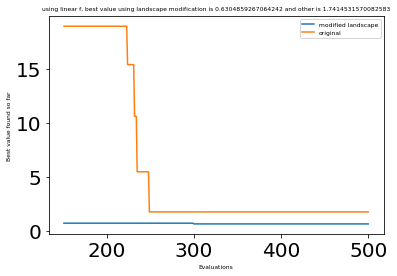

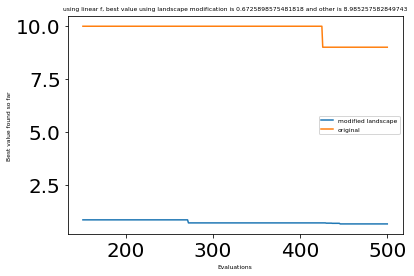

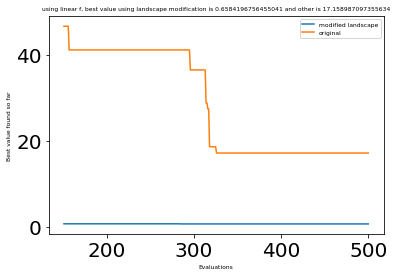

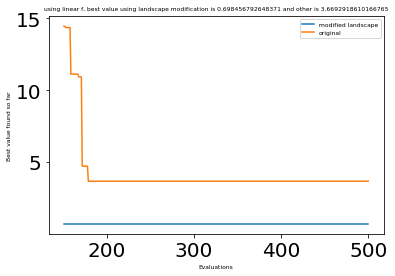

dixon price, square root landscape modification, zero c
landscape modified was better 30 times and was worse 0 times
mean of landscape modified is 0.6337928511317138
mean of non landscape modified is 4.804932585324815
median of landscape modified is 0.6283927658566506
median of non landscape modified is 3.752288751282012
best result of landscape modified is 0.5527144987198359
best of non landscape modified is 1.372994266130958
worst result of landscape modified is 0.7547331027277238
worst of non landscape modified is 17.158987097355634


([0.626299605006877,
  0.5728571749979274,
  0.7547331027277238,
  0.6821245486941655,
  0.6181291262803137,
  0.5527144987198359,
  0.6128262297394764,
  0.6818579412033108,
  0.637104532115023,
  0.6748716609778753,
  0.5838836604076898,
  0.6463780530405063,
  0.6716106367454101,
  0.6470460813069527,
  0.6114240757936882,
  0.6843804432787768,
  0.6013797387271994,
  0.648224146201392,
  0.6254609371565029,
  0.5857193012588751,
  0.590824038140473,
  0.5903694196559834,
  0.580419547109233,
  0.5836492789038793,
  0.668357498392468,
  0.6211880048213694,
  0.6304859267064242,
  0.6725898575481818,
  0.6584196756455041,
  0.698456792648371],
 [1.372994266130958,
  1.867095032073057,
  6.24140878611455,
  5.099598779697996,
  6.364452000731959,
  4.484170840172756,
  4.927681862501998,
  2.267706130229823,
  10.991773874592724,
  2.622478374296363,
  2.9481653342808594,
  5.1895026759341985,
  2.8910164618022227,
  2.7773238463898466,
  3.7233758589480614,
  2.0346747991725334,
  5.

In [118]:
checker(30,path,l2)

In [ ]:
# why is adaptive c square landscape so bad?